# 等离子体电子声波：Two-temperature Electrons Model

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import plasmapy.mathematics
import scipy.signal
import scipy.optimize as op
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
%config InlineBackend.figure_format = 'svg'

## 模型
### 1D等离子体：双温运动电子+静止均匀分布离子
- 初始分布函数
$$ f(x,v,0) = \left[ \frac{n_c}{\sqrt{2\pi T_c}} \exp{\left( -\frac{v^2}{2T_c} \right)} + \frac{n_h}{\sqrt{2\pi T_h}} \exp{\left( -\frac{v^2}{2T_h} \right)} \right] (1+d \cos kx) $$
             
- EAW色散关系
$$ \omega_r^2 = \frac{n_c}{n_h} k^2 v^2_h \frac{1+3k^2\lambda_c^2+3\lambda_c^2/\lambda_h^2}{1+k^2\lambda_h^2}$$
或
$$ \omega_r^2 = \omega_c^2 \frac{1+3k^2\lambda_c^2+3\lambda_c^2/\lambda_h^2}{1+1/(k^2\lambda_h^2)}$$
当$\lambda_c << \lambda_h$时
$$ \omega_r^2 = \omega_c^2 \frac{1+3k^2\lambda_c^2}{1+1/(k^2\lambda_h^2)}$$

- 注意在$k \lambda_h >>1$时，色散关系变为
$$ \omega_r^2 = \omega_c^2 (1+3k^2\lambda_c^2)$$
即冷电子组分的Langmuir波

- 让EAW展现出来的关键在于
    - 排除热电子LW，$\gamma_{EAW} < \gamma_{LW}^{hot}$
    - 排除冷电子LW，$k \lambda_h \le 1$
    - EAW本身不能过阻尼，$\gamma_{EAW} \le \omega_r/(2\pi)$，满足此条件可获得存在较长时间的EAW
- EAW和LW的阻尼率：
$$ |\gamma_{EAW}| = \sqrt{\frac{\pi}{8}} \frac{n_c}{n_h} k v_h \frac{1+3k^2\lambda_c^2+3\lambda_c^2/\lambda_h^2}{(1+k^2\lambda_h^2)^2}$$
$$ |\gamma_{LW}|  = \sqrt{\frac{\pi}{8}} \omega_s\frac{1 + 3k^2 \lambda_s^2}{k^3 \lambda_s^3} \exp\left( -\frac{1}{2 k^2 \lambda_s^2} - \frac{3}{2} \right)$$

In [469]:
# 等离子体基本参数
n = 1
q = 1
m = 1
T = 1

nc = 0.2
nh = n-nc
b = 100 #Th/Tc
Tc = 0.01 #n*T/(nc+nh*b)
Th = b*Tc
l_D = np.sqrt( T / n / q**2 ) # $\lambda_D^2$
w_pe = np.sqrt( n * q**2 )
w_pc = np.sqrt( nc * q**2 )
w_ph = np.sqrt( nh * q**2 )
l_D_c = np.sqrt(Tc/nc)
l_D_h = np.sqrt(Th/nh)
v_c = np.sqrt(Tc/m)
v_h = np.sqrt(Th/m)

print('nc = ',nc)
print('nh = ',nh)
print('Tc = ',Tc)
print('Th = ',Th)
print('w_pc = ',w_pc)
print('w_ph = ',w_ph)
print('l_D_c = ',l_D_c)
print('l_D_h = ',l_D_h)

nc =  0.2
nh =  0.8
Tc =  0.01
Th =  1.0
w_pc =  0.4472135954999579
w_ph =  0.8944271909999159
l_D_c =  0.22360679774997896
l_D_h =  1.118033988749895


## 数值验证

### 模拟参数设定

In [453]:
k = 0.7
L = 2*np.pi/k

vmax = 6 # 速度最大值
nx = 401
nv = 601
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
dt = 0.01
max_steps  = 30000
data_steps = 2000
data_num = int(max_steps/data_steps)+1
d = 0.001

path = '../data/'
print(data_num)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

16
limited time= 448.79895051282756
real time =  300.0


- 计算LW和EAW的$\omega$和$\gamma$

In [454]:
klc = 1+3*k**2*l_D_c**2
klh = 1+3*k**2*l_D_h**2

w_lw_c = w_pc*np.sqrt(klc)
w_lw_h = w_ph*np.sqrt(klh)
w_eaw = w_pc*np.sqrt((klc+3*l_D_c**2/l_D_h**2)/(1+1/(k*l_D_h)**2))
v_lw_c = w_lw_c/k
v_lw_h = w_lw_h/k
v_eaw = w_eaw/k
r_eaw = np.sqrt(np.pi/8) * nc/nh * (klc)/(1+k**2*l_D_h**2)**2 *k*np.sqrt(Th)
r_lw_c= np.sqrt(np.pi/8) * (w_pc/k**3/l_D_c**3) * klc * np.exp(-0.5/(k*l_D_c)**2-1.5)
r_lw_h= np.sqrt(np.pi/8) * (w_ph/k**3/l_D_h**3) * klh * np.exp(-0.5/(k*l_D_h)**2-1.5)

In [455]:
dr_table = PrettyTable(['k = '+str(k),'wr','wi','wr/k'])
dr_table.add_row(['LW (hot)',round(w_lw_h,6),round(r_lw_h,6),round(v_lw_h,6)])
dr_table.add_row(['LW(cold)',round(w_lw_c,6),round(r_lw_c,6),round(v_lw_c,6)])
dr_table.add_row(['EAW',round(w_eaw,6),round(r_eaw,6),round(v_eaw,6)])
print(dr_table)

+----------+----------+----------+----------+
| k = 0.7  |    wr    |    wi    |   wr/k   |
+----------+----------+----------+----------+
| LW (hot) | 1.506652 | 0.327253 | 2.15236  |
| LW(cold) | 0.463357 |   0.0    | 0.661939 |
|   EAW    | 0.301113 | 0.045276 | 0.430161 |
+----------+----------+----------+----------+


### EAW条件检验
- $\gamma_{EAW} < \gamma_{LW}^{hot}$

In [456]:
print('r_eaw     = ',round(r_eaw,6))
print('r_lw(hot) = ',round(r_lw_h,6))

r_eaw     =  0.045276
r_lw(hot) =  0.327253


- $k\lambda_h \le 1$

In [457]:
print('k*l_D_h = ',round(k*l_D_h,6))

k*l_D_h =  0.782624


- $\gamma_{EAW} < \omega_r/(2\pi)$

In [458]:
print('r_eaw   = ',round(r_eaw,6))
print('wr/2/pi = ',round(w_eaw/2/np.pi,6))

r_eaw   =  0.045276
wr/2/pi =  0.047924


## 模拟结果

In [459]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

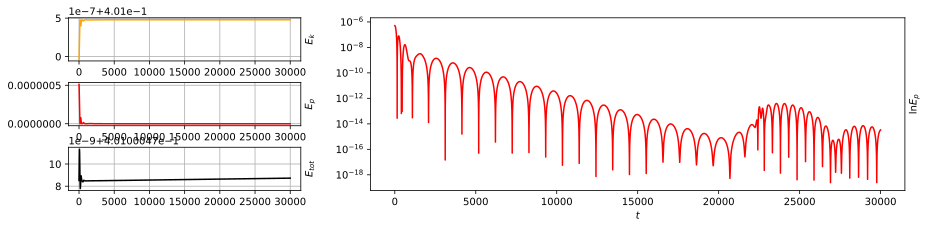

In [460]:
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.grid()
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 3), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.grid()
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.grid()
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 3), (0, 1),colspan=2, rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.3)
plt.xlabel(r'$t$')
plt.show()

In [461]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [462]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L

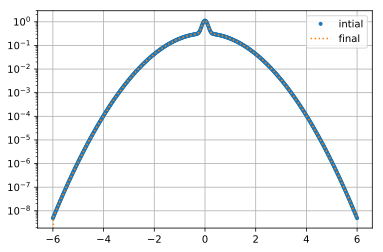

In [463]:
plt.plot(v,fv0,'.',label='intial')
plt.plot(v,fv,':',label='final')
# plt.plot(v,f_d(v),'--',label=r'Maxwellian')
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()

$$ E_p \propto E^2 \propto \left( e^{i \omega_r t+\omega_i t} \right)^2 = e^{i 2\omega_r t+2\omega_i t} $$

In [464]:
def PlotWaveFreq(t,y,refFreq,refFreq2):
    n = t.size
    y_k = fftpack.fft(y)
    x_k = fftpack.fftfreq(len(y_k),dt)
    y_k_abs = np.abs(y_k)
    y_k_phi = np.angle(y_k)

    plt.figure(figsize=(10,3))
    
    ax2 = plt.subplot()
    k_plot_scale=n//30
    ax2.plot(np.pi*x_k[1:k_plot_scale],2*y_k_abs[1:k_plot_scale]/n,color='black',lw=2)
    ax2.axvline(refFreq,color='red',ls='--',label=r'$\omega_1$ = '+str(round(refFreq,6)))
    ax2.axvline(refFreq2,color='orange',ls='--',label=r'$\omega_2$ = '+str(round(refFreq2,6)))
    ax2.set_title('freq-wave')
    ax2.set_xlabel(r'$\omega$')
    ax2.set_ylabel('A')
    ax2.grid()
    ax2.legend()
    
    plt.show()
    
def line(p, x):
    k, b = p
    return k*x+b

def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r

def period(x):
    return (x[1]-x[0])/1.

def errPercent(a, b):
    r = abs((a-b)/b)
    return r

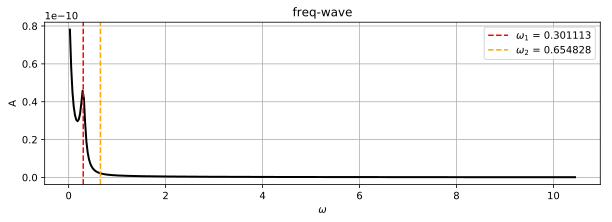

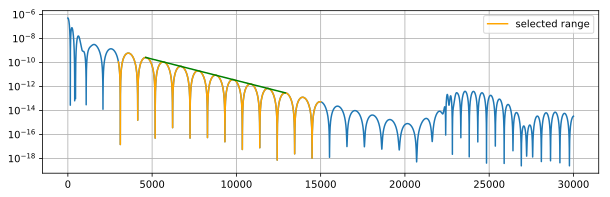

In [467]:
start = 3000
end = 15000

indexes, _ = scipy.signal.find_peaks(dataep, distance=5)
xep = indexes[6:15:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
wr_sim = 2*np.pi/per_sim/2
wi_sim = para[0]/dt/2

PlotWaveFreq(t[start:end],dataep[start:end],w_eaw,w_lw)
fig = plt.figure(figsize=(10,3))
plt.plot(t,dataep)
plt.plot(t[start:end],dataep[start:end],color='orange',label='selected range')
plt.plot(xep,np.exp(line(para,xep)), '-',color='green')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [468]:
wr_err = abs(wr_sim-w_eaw)/w_eaw*100
wi_err = abs(abs(wi_sim)-r_eaw)/abs(r_eaw)*100
com_table = PrettyTable(['EAW: k='+str(k),'wr','wi'])
com_table.add_row(['Theory',round(w_eaw,6),round(r_eaw,6)])
com_table.add_row(['Simulation',round(wr_sim,6),round(abs(wi_sim),6)])
com_table.add_row(['Error(%)',round(wr_err,6),round(abs(wi_err),6)])
print(com_table)

+------------+----------+----------+
| EAW: k=0.7 |    wr    |    wi    |
+------------+----------+----------+
|   Theory   | 0.301113 | 0.045276 |
| Simulation | 0.303829 | 0.041008 |
|  Error(%)  | 0.902038 | 9.426262 |
+------------+----------+----------+
